In [1]:
import numpy as np
import scipy as sp
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import numpy.ma as ma
import seaborn as sns
import scipy.optimize
from matplotlib import cm
from numpy import unravel_index
from scipy.stats import ks_2samp

plt.rcParams.update({'font.size': 12})

warnings.filterwarnings(action='ignore')

from plotting_utilities import *
from thermodynamic_functions import *

In [2]:
g = 9.8 # gravitational acceleration [m s-2]
rho_air = 1.395 # density of air (kg m-3)
rho_water = 1000 #density of water (kg m-3)
eps = 0.01802/0.02897 # ratio of MW_water to MW_air

In [7]:
# array of years
#years = np.arange( 1983, 2008 )
years = np.arange( 2000, 2001 )

# create list of file names
#file_years = file_concatenator_ERAI(years)
file_years = file_concatenator_ERA5(years)

# Are we only looking at tropical MCSs?
minlat_array = nc_open_compile(file_years,"min latitude").values
maxlat_array = nc_open_compile(file_years,"max latitude").values
cape_array = nc_open_compile(file_years,"cape_mean").values # SS 20250209 "cape" -> "cape_mean"

tropical_indx = np.argwhere( (minlat_array >= -10) & (maxlat_array <= 10) & (cape_array > 10))[:,0]
tropical_rain_indx = tropical_indx #np.argwhere( (minlat_array >= -10) & (maxlat_array <= 10) &
                                  #(pmax_array >= np.percentile(pmax_array,75)) & (cape_array > 10) )[:,0]
print(tropical_indx.shape)
print(tropical_rain_indx.shape)

# applying same for MCS lifetime and morphology
lifetime_array = nc_open_compile(file_years,"lifetime")
lifetime_ERA = negative_to_nan(lifetime_array)[tropical_rain_indx]
rad_array = nc_open_compile(file_years,"rad")
rad_ERA = negative_to_nan(rad_array)[tropical_rain_indx]
ctt_array = nc_open_compile(file_years,"ctt")
ctt_ERA = negative_to_nan(ctt_array)[tropical_rain_indx]
rad_array = nc_open_compile(file_years,"rad")
rad_ERA = negative_to_nan(rad_array)[tropical_rain_indx]
minctt_array = nc_open_compile(file_years,"minctt")
minctt_ERA = negative_to_nan(minctt_array)[tropical_rain_indx]
cape_ERA = negative_to_nan(cape_array)[tropical_rain_indx]

# Read in the vertical velocities
omega_array = nc_open_compile(file_years,"w_mean",'stack')[tropical_rain_indx] # SS 20250209 "omega" -> "w_mean"
# Extract the value around 200 hPa
omega_ERA_mid = omega_array[:,4]
# Filter for negative values of omega (ascent rates)
omega_ERA_mid_n, cape_ERA_n = negative_vals( omega_ERA_mid, cape_ERA )

(32869,)
(32869,)


In [8]:
def scatter_hist(x, y, xbins, ybins, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    h = ax.hist2d( x, y, bins=(xbins, ybins), cmap=cm.Blues )
    wgts = np.ones_like(x)/float(len(x))*100
    ax_histx.hist(x, bins=xbins, edgecolor='k', weights=wgts )
    ax_histx.tick_params(axis='both', which='major', labelsize=font_size-5)
    wgts = np.ones_like(y)/float(len(y))*100
    ax_histy.hist(y, bins=ybins, edgecolor='k', weights=wgts, orientation='horizontal')
    ax_histy.tick_params(axis='both', which='major', labelsize=font_size-5)
    #ax_histy.set_yscale('log')
    return h

In [9]:
_, rad_ERA_n = negative_vals( omega_ERA_mid, rad_ERA )
_, minctt_ERA_n = negative_vals( omega_ERA_mid, minctt_ERA )
_, lifetime_ERA_n = negative_vals( omega_ERA_mid, lifetime_ERA )
_, ctt_ERA_n = negative_vals( omega_ERA_mid, ctt_ERA )
ascent200_list = [ omega_ERA_mid_n, omega_ERA_mid_n[rad_ERA_n <= np.percentile(rad_ERA_n,25)],
                    omega_ERA_mid_n[rad_ERA_n >= np.percentile(rad_ERA_n,75)],
                    omega_ERA_mid_n[minctt_ERA_n <= np.percentile(minctt_ERA_n,25)],
                    omega_ERA_mid_n[minctt_ERA_n >= np.percentile(minctt_ERA_n,75)],
                    omega_ERA_mid_n[lifetime_ERA_n <= np.percentile(lifetime_ERA_n,25)],
                    omega_ERA_mid_n[lifetime_ERA_n >= np.percentile(lifetime_ERA_n,75)] ]

In [11]:
# Are the histograms of omega_200^(-) statistically significantly different when stratifying for extent?
i = np.argwhere( ~np.isnan(ascent200_list[0].values) )
data1 = ascent200_list[0][i[:,0]]

i = np.argwhere( ~np.isnan(ascent200_list[1].values) )
data2 = ascent200_list[1][i[:,0]]

i = np.argwhere( ~np.isnan(ascent200_list[2].values) )
data3 = ascent200_list[2][i[:,0]]

statistic, p_value = ks_2samp( data1, data2 )
print( statistic, p_value )

statistic, p_value = ks_2samp( data1, data3 )
print( statistic, p_value )

statistic, p_value = ks_2samp( data2, data3 )
print( statistic, p_value )

0.09453941513436281 4.85462278457824e-41
0.14069710488657472 4.119370605335168e-88
0.23454111347395445 8.294078466327684e-157


In [15]:
# Are the histograms of omega_550^(-) statistically significantly different when stratifying for depth or lifetime?
i = np.argwhere( ~np.isnan(ascent200_list[0].values) )
data1 = ascent200_list[0][i[:,0]]

i = np.argwhere( ~np.isnan(ascent200_list[3].values) )
data2 = ascent200_list[3][i[:,0]]

i = np.argwhere( ~np.isnan(ascent200_list[4].values) )
data3 = ascent200_list[4][i[:,0]]

i = np.argwhere( ~np.isnan(ascent200_list[5].values) )
data4 = ascent200_list[5][i[:,0]]

i = np.argwhere( ~np.isnan(ascent200_list[6].values) )
data5 = ascent200_list[6][i[:,0]]

statistic, p_value = ks_2samp( data1, data2 )
print( statistic, p_value )

statistic, p_value = ks_2samp( data1, data3 )
print( statistic, p_value )

statistic, p_value = ks_2samp( data2, data3 )
print( statistic, p_value )
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

statistic, p_value = ks_2samp( data1, data4 )
print( statistic, p_value )

statistic, p_value = ks_2samp( data1, data5 )
print( statistic, p_value )

statistic, p_value = ks_2samp( data4, data5 )
print( statistic, p_value )

0.07267921994830362 1.649429349735706e-26
0.04768309729145237 1.068638210379896e-10
0.11977823634985661 1.2992716945888392e-43
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.019428031556752323 0.009681119788243327
0.061573766496794136 2.153628996409066e-17
0.08029142583820863 3.0357728301471223e-22


0.41789838820695846
0.4927671104669571
0.2934617495536808


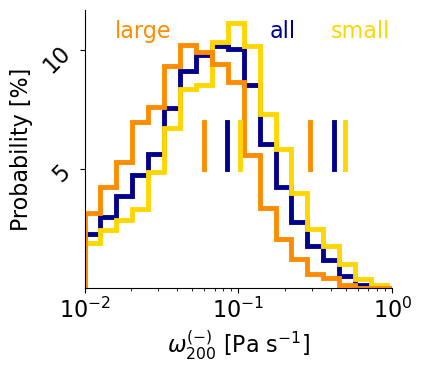

In [18]:
fig = plt.figure( figsize=(4.5,4), constrained_layout=True )
font_size = 16
fs = 16
plt.rcParams.update({
    'font.size':font_size,
    'axes.labelsize':font_size,
    'xtick.labelsize':font_size,
    'ytick.labelsize':font_size,
    'legend.fontsize':font_size,
})

farbe = [ 'darkblue', 'gold', 'darkorange', 'turquoise', 'lawngreen', 'pink', 'red' ]
lw = 3.5
for j in np.arange(3):
    i = np.argwhere( ~np.isnan(ascent200_list[j].values) )
    wgts = np.ones_like( ascent200_list[j][i[:,0]] ) / float(len( ascent200_list[j][i[:,0]] ))*100 
    h, edges = np.histogram( ascent200_list[j][i[:,0]], weights=wgts, bins=np.logspace(-2,1,30) )
    plt.stairs( h, edges, edgecolor=farbe[j], lw=lw )#, label=lbls[j][k] )
    m = np.nanmean(ascent200_list[j][i[:,0]])
    plt.plot( [m, m], [5, 7], color=farbe[j], lw=lw )
    m = np.nanpercentile(ascent200_list[j][i[:,0]], 99)
    print(m)
    plt.plot( [m, m], [5, 7], color=farbe[j], lw=lw )
        
plt.gca().set_xscale( 'log' )
plt.gca().set_xlim( [10**(-2),1] )
plt.gca().set_xlabel( r'$\omega_{200}^{(-)}$ [Pa s$^{-1}$]' )
plt.gca().set_ylabel( 'Probability [%]' )
plt.gca().set_yticks([5, 10])
plt.gca().text( 0.1, 0.9, 'large', color='darkorange', fontsize=fs, transform=plt.gca().transAxes )
plt.gca().text( 0.6, 0.9, 'all', color='darkblue', fontsize=fs, transform=plt.gca().transAxes )
plt.gca().text( 0.8, 0.9, 'small', color='gold', fontsize=fs, transform=plt.gca().transAxes )


plt.gca().spines['top'].set_visible( False )
plt.gca().spines['right'].set_visible( False )
for t in plt.gca().get_yticklabels():
    t.set_rotation(45)

plt.tight_layout()
#

fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/ascent-200-ERA.pdf', bbox_inches='tight' )
plt.show()